In [ ]:
!wget 'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip'

--2021-06-03 07:35:42--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.37.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.37.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247694507 (236M) [application/zip]
Saving to: ‘processed-celeba-small.zip’

processed-celeba-sm 100%[===================>] 236.22M  45.1MB/s    in 5.7s    

2021-06-03 07:35:48 (41.4 MB/s) - ‘processed-celeba-small.zip’ saved [247694507/247694507]



In [ ]:
!unzip processed-celeba-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: processed_celeba_small/celeba/New Folder With Items/052332.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg  
  inflating: 

In [ ]:
data_dir = 'processed_celeba_small/'
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    data_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])
    
    dataFolder = datasets.ImageFolder(data_dir, transform = data_transforms)
    
    dataloader = DataLoader(dataFolder, batch_size = batch_size, shuffle=True)
    
    return dataloader


In [ ]:
batch_size = 128
img_size = 32
celeba_train_loader = get_dataloader(batch_size, img_size)


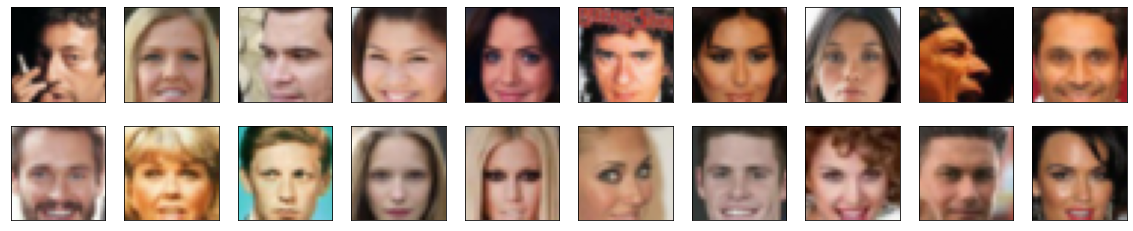

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() 
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [ ]:

img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(0.9725)


In [ ]:
def scale(x, feature_range=(-1, 1)):
    min_i, max_i = feature_range
    x = x * (max_i - min_i)+ min_i
    return x


In [ ]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.9451)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)
    

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim,4,batch_norm=False)#input: 32 X 32 X 3 ==> output: 16 X 16 X conv_dim
        
        self.conv2 = conv(conv_dim, conv_dim*2, 4) #input: 16 X 16 X conv_dim ==> output: 8 X 8 X conv_dim*2
        
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) #input: 8 X 8 X conv_dim*2 ==> output: 4 X 4 X conv_dim*4
        
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) #input: 4 X 4 X conv_dim*4 ==> output: 2 X 2 X conv_dim*8
        self.fc = nn.Linear(2*2*(conv_dim*8), 1)
        

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = out.view(-1, 2*2*(self.conv_dim*8))
        out = self.fc(out)
        
        return out


In [ ]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False)
    
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()

        self.z_size = z_size
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        self.t_conv0 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)        #input: 4 X 4 X conv_dim*4 ==> output: 8 X 8 X conv_dim*2
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)          #input: 8 X 8 X conv_dim*2 ==> output: 16 X 16 X conv_dim
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False) #input: 16 X 16 X conv_dim ==> output: 32 X 32 X 3
        
        

    def forward(self, x):
        out = self.fc(x)
        
        out = out.view(-1, self.conv_dim*8, 2, 2) # (Batch_Size, Depth, 2, 2)
        out = F.relu(self.t_conv0(out))
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        out = self.t_conv3(out)
        out = torch.tanh(out) 
        return out


In [ ]:
from torch.nn import init

def weights_init_normal(m):
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv')!=-1 or classname.find('Linear')!=-1):
        init.normal_(m.weight.data, mean=0.0, std=0.02)
        
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()
    
    

In [ ]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [ ]:
d_conv_dim = 64
g_conv_dim = 64
z_size = 100
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv0): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fal

In [ ]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [ ]:
def real_loss(D_out, smooth=False):
    
    batch_size  = D_out.size(0)
    
    labels = torch.ones(batch_size)
    
    if smooth:
        labels = labels*0.9
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [ ]:
import torch.optim as optim
lr = 0.0002
beta1= 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, betas = (beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr, betas = (beta1, beta2))

In [ ]:
def train(D, G, n_epochs, print_every=50):
    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):

        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            D_real_loss = real_loss(D_real, smooth=True)
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z= z.cuda()
                
            fake_images = G(z)
            
            D_fake = D(fake_images)
            D_fake_loss = fake_loss(D_fake)

            d_loss = D_real_loss + D_fake_loss
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            D_fake = D(fake_images)
            
            g_loss = real_loss(D_fake, smooth=True)
            
            g_loss.backward()
            g_optimizer.step()
            

            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        G.eval() 
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses

In [ ]:
n_epochs = 2
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/    2] | d_loss: 1.9798 | g_loss: 2.1844
Epoch [    1/    2] | d_loss: 0.5685 | g_loss: 3.6962
Epoch [    1/    2] | d_loss: 0.6328 | g_loss: 5.0431
Epoch [    1/    2] | d_loss: 0.6468 | g_loss: 4.2199
Epoch [    1/    2] | d_loss: 0.7435 | g_loss: 3.6945
Epoch [    1/    2] | d_loss: 0.7007 | g_loss: 3.6154
Epoch [    1/    2] | d_loss: 0.8959 | g_loss: 4.4705
Epoch [    1/    2] | d_loss: 1.2839 | g_loss: 4.2947
Epoch [    1/    2] | d_loss: 0.7294 | g_loss: 1.9420
Epoch [    1/    2] | d_loss: 0.7155 | g_loss: 2.5607
Epoch [    1/    2] | d_loss: 1.0142 | g_loss: 3.5749
Epoch [    1/    2] | d_loss: 1.0340 | g_loss: 3.5600
Epoch [    1/    2] | d_loss: 0.7798 | g_loss: 2.0651
Epoch [    1/    2] | d_loss: 1.1967 | g_loss: 2.6343
Epoch [    1/    2] | d_loss: 0.8864 | g_loss: 2.5585
Epoch [    2/    2] | d_loss: 0.9963 | g_loss: 1.4428
Epoch [    2/    2] | d_loss: 0.9533 | g_loss: 2.8886
Epoch [    2/    2] | d_loss: 1.1540 | g_loss: 1.5102
Epoch [    2/    2] | d_loss

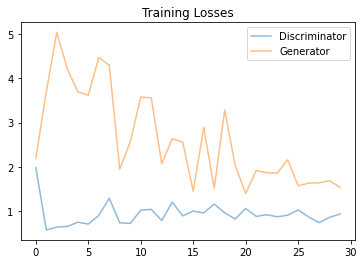

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

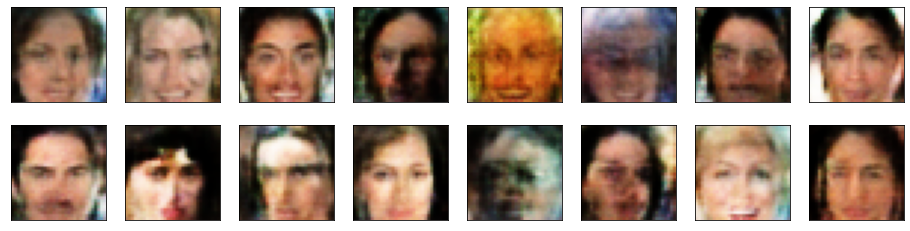

In [ ]:
_ = view_samples(-1, samples)